# Strategies to deal with unknown class

## Common Parameters

In [1]:
sys.path.append("..") # Adds higher directory to python modules path.
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *
from helpers import *
from visuals import *
from data.data_loader import *
from collections import Counter

import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from visuals import plot_confusion_matrix
from tensorflow.keras import utils
from keras_numpy_backend import categorical_crossentropy

%load_ext autoreload
%autoreload 2
%matplotlib inline

data_folder = '../data/isic2019/sampled_original'

model_name = 'DenseNet201'
postfix = 'best_balanced_acc'

pred_folder="test_predict_results"

workers = os.cpu_count()

# How to handle SVG fonts
plt.rcParams['svg.fonttype'] = 'none'

predict_folder = os.path.join(
    "..", 
    pred_folder,
    model_name, 
    formated_hyperparameter_str(6, 0.001, 0.00001, None, 0.3, 16, 20264, False)
)

unknown_threshold_paths = [o for o in os.listdir(predict_folder) if os.path.isdir(os.path.join(predict_folder,o))]

pred_folders = []

for i, path in enumerate(unknown_threshold_paths): 
    file_path = os.path.join(predict_folder, path, "best_balanced_acc.csv")
    pred_folders.append({"file_path": file_path, "unknown":path.replace("_", " ")})

TypeError: formated_hyperparameter_str() missing 2 required positional arguments: 'balanced' and 'data_augmentation_group'

# Compute test metrics with unknown class
# DenseNet201:
* Feature extract epochs: 6.
* Start learning rate: 0.001000
* Fine tuning learning rate: 0.000010
* Dropout rate: 0.300000
* Lambda(l2): None
* Batch size: 16

## Test data distribution

Test data has 5195 samples.
'MEL':	904	(17.40%)
'NV':	2575	(49.57%)
'BCC':	665	(12.80%)
'AK':	173	(3.33%)
'BKL':	525	(10.11%)
'DF':	48	(0.92%)
'VASC':	51	(0.98%)
'SCC':	126	(2.43%)
'UNK':	128	(2.46%)


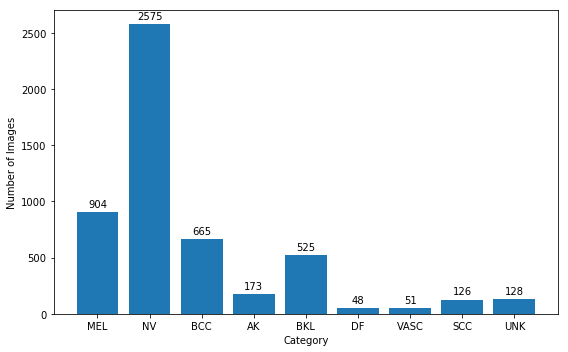

In [15]:
training_image_folder = os.path.join(data_folder, 'ISIC_2019_Test_Input')
ground_truth_file = os.path.join(data_folder, 'ISIC_2019_Test_GroundTruth_Unknown.csv')

df_test_ground_truth, known_category_names, unknown_category_name = load_isic_training_data(
    training_image_folder, 
    ground_truth_file,
    test=True
)
known_category_num = len(known_category_names)
unknown_category_num = 1
all_category_names = known_category_names + [unknown_category_name]
all_category_num = known_category_num + unknown_category_num

count_per_category = Counter(df_test_ground_truth['category'])
total_sample_count = sum(count_per_category.values())
print("Test data has {} samples.".format(total_sample_count))
for i, c in enumerate(all_category_names):
    print("'%s':\t%d\t(%.2f%%)" % (c, count_per_category[i], count_per_category[i]*100/total_sample_count))

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')
ax.set(xlabel='Category', ylabel='Number of Images')
rects = plt.bar(all_category_names, [count_per_category[i] for i in range(all_category_num)])
autolabel(ax, rects)
fig.tight_layout()

## Threshold comparisson

>>>>>>>>>>>>>>>>>>> no unknown <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.7778633301251203
balanced_accuracy_score:  0.5745314668770142
macro recall_score:  0.5745314668770142


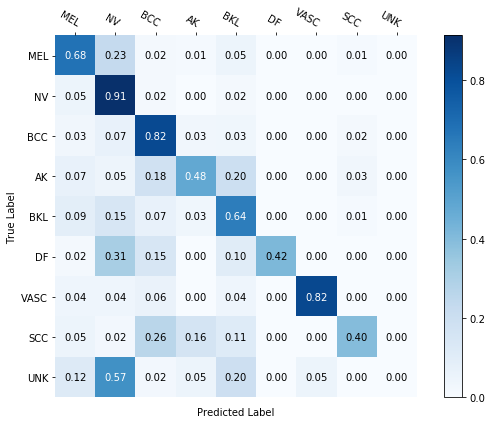

>>>>>>>>>>>>>>>>>>> unknown 0.2 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.7778633301251203
balanced_accuracy_score:  0.5745314668770142
macro recall_score:  0.5745314668770142


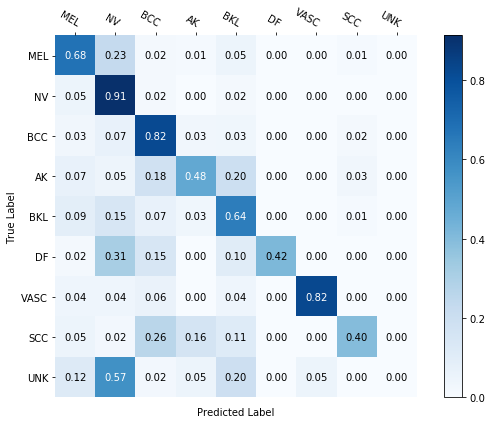

>>>>>>>>>>>>>>>>>>> unknown 0.25 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.7778633301251203
balanced_accuracy_score:  0.5745314668770142
macro recall_score:  0.5745314668770142


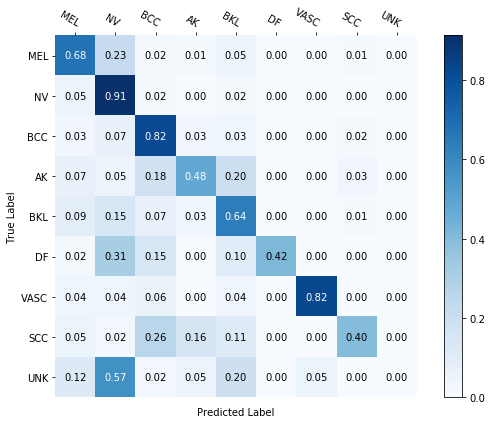

>>>>>>>>>>>>>>>>>>> unknown 0.3 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.7778633301251203
balanced_accuracy_score:  0.5745314668770142
macro recall_score:  0.5745314668770142


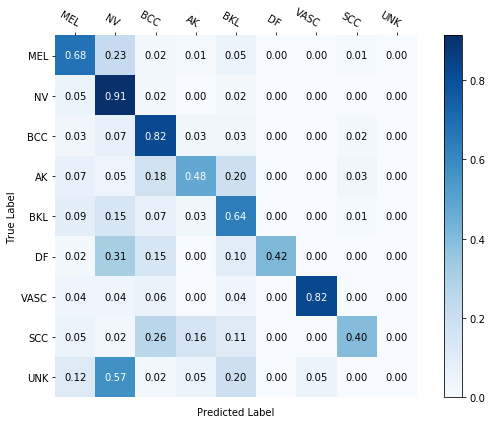

>>>>>>>>>>>>>>>>>>> unknown 0.35 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.7774783445620789
balanced_accuracy_score:  0.5742766767193114
macro recall_score:  0.5742766767193114


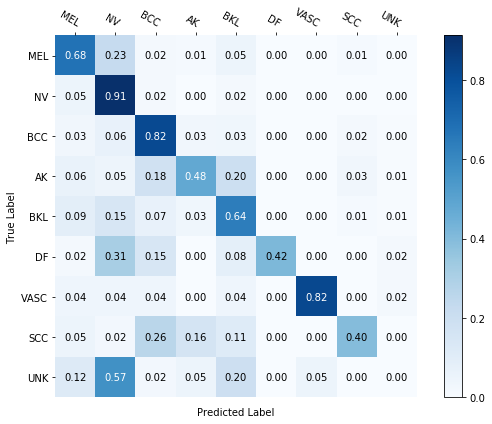

>>>>>>>>>>>>>>>>>>> unknown 0.4 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.7774783445620789
balanced_accuracy_score:  0.5773726041506572
macro recall_score:  0.5773726041506572


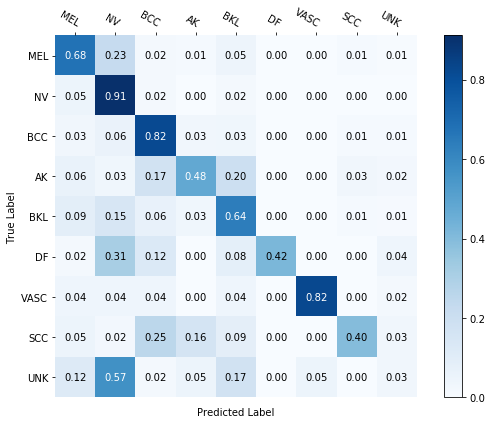

>>>>>>>>>>>>>>>>>>> unknown 0.45 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.7751684311838306
balanced_accuracy_score:  0.5754091970691414
macro recall_score:  0.5754091970691414


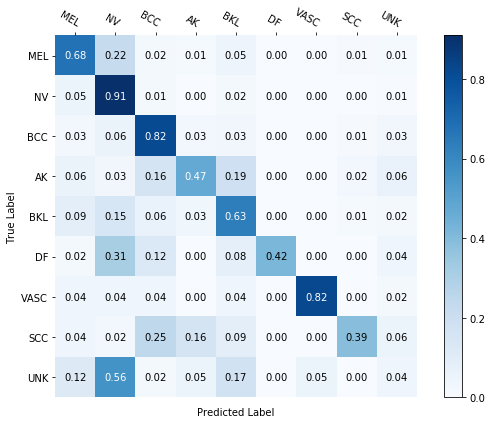

>>>>>>>>>>>>>>>>>>> unknown 0.5 <<<<<<<<<<<<<<<<<<<<<
accuracy:  0.7715110683349374
balanced_accuracy_score:  0.573009716611193
macro recall_score:  0.573009716611193


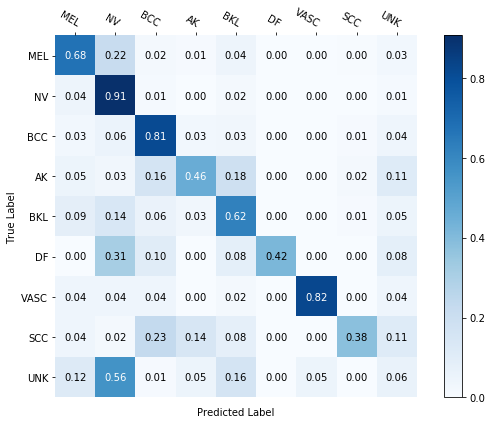

In [21]:
for pred_unknown_threshold in pred_folders:
    df_pred = pd.read_csv(pred_unknown_threshold["file_path"])
    df = pd.merge(df_pred, df_test_ground_truth, on='image')
    y_true = df['category']
    y_pred = df['pred_category']
    df.to_csv("test.csv")

    print(f">>>>>>>>>>>>>>>>>>> {pred_unknown_threshold['unknown']} <<<<<<<<<<<<<<<<<<<<<")
    # Compute Balanced Accuracy
    print('accuracy: ', accuracy_score(y_true, y_pred))
    print('balanced_accuracy_score: ', balanced_accuracy_score(y_true, y_pred))
    print('macro recall_score: ', recall_score(y_true, y_pred, average='macro'))
    # Confusion Matrix
    plot_confusion_matrix(
        y_true, 
        y_pred, 
        all_category_names, 
        normalize=True,
        figsize=(8, 6)
    )
    plt.show()